# Lecture 19 (5/9/2022)

**Announcements**


*Last time we covered:*
- Evaluating classification algorithms

**Today's agenda:**
- Evaluating classification algorithms cont'd (ROC curves)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Advanced classifier evaluation: ROC curves

First, let's load in the `iris` dataset and remind ourselves what it is we're classifying to begin with...

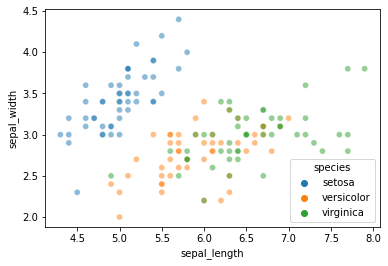

In [2]:
iris = sns.load_dataset('iris')
iris

sns.scatterplot(data = iris, x = "sepal_length", y = "sepal_width", hue = "species", alpha = 0.5)
plt.show()

Last time, we discussed:
- How to fit a $k$-nearest neighbors (k-NN) classification model to this data 
- How to evaluate its performance on held-out or cross-validated test data

Let's quickly review this together by having you code and run the steps above yourself!

In [3]:
# Let's start by changing this to a binary classification problem
iris['species_binary'] = iris['species'].map({'versicolor': 'versicolor',
                                             'virginica': 'non-versicolor',
                                             'setosa': 'non-versicolor'})


In [4]:
### YOUR CODE HERE

# 1. Select the `sepal_length` and `sepal_width` columns as X values




# 2. Select the `species_binary` column we generated above as y values




# 3. Use the `train-test-split` function to generate a set of training and test data points 
    # Use 0.2 for the test portion and set `random_state = 0` to make our results identical
    # Don't forget to call `reset_index(drop = True)` for each of your train/test datasets




In [5]:
### YOUR CODE HERE

# 4. Fit an sklearn `KNeighborsClassifier` instance to this data with 3 neighbors



# 5. Evaluate the classifier using accuracy as a baseline metric



# 6. Evaluate the classifier with a more sophisticated metric like F1 score




## Hard and Soft Classification

The $k$-nearest neighbors classifier chooses a predicted label $\hat{\lambda}$ for a new set of features $\theta$ by selecting the *mode* of the labels of the nearest training items. 

In this way, you can think of the nearest neighbors as essentially "voting" for the label of each test item. This produces a single label prediction for each test item. Put another way, all the predictions for our test items in the example above are either `'versicolor'` or `'non-versicolor'`. This sort of model *decision policy* is referred to as **Hard Classification**. 

**But, it doesn't need to be this way.** We can also represent the "votes" of the nearest neighbors as generating a *probability distribution* over $\hat{\lambda}$ values. 
- For example, if there are 3 nearest neighbors for our new item and 2 are 'versicolor' and 1 is 'non-versicolor', we can represent the new item as having a 2/3 chance of being 'versicolor'. 
- Many of the classification algorithms we'll discuss can assign a *probability* of a particular label for a given test item rather than a strict label assignment.

This form of classification is called **Soft Classification**. 

The `sklearn` `KNeighborsClassifier` class exports a `predict_proba` function that is just like the `predict` function except instead of showing us the *hard predictions* for each test item, it shows us the *soft prediction* probabilities:

In [6]:
# Here's the original `predict` function
knn.predict(X = xtest)



NameError: name 'knn' is not defined

In [7]:
# Here's the graded probability prediction
knn.predict_proba(X = xtest)



NameError: name 'knn' is not defined

In the predictions above, the first column is the probability of 'non-versicolor' and the second is the probability of 'versicolor'.

This *Soft Classification* allows us to set more flexible decision policies about what kind of label $\hat{\lambda}$ we want to assign to a given test item. Using the *mode* of the nearest neighbor labels in k-NN classification sets a **classification threshold** of 50% (for binary classification), but we could choose any threshold we want depending on the problem.
- In some cases, we may want to predict a label value whenever *any* of the neighbors have that label (ex. risk of a fatal disease).
- Or, maybe we only want to predict a particular label if 90% of the neighbors have that label (ex. setting a high parole). 

However, the classification threshold we set will effect how often we assign a particular label to new pieces of data.

*Why does this matter?*

## Different thresholds change evaluation metrics

Critically, our choice of classification threshold will affect our evaluation metrics above in predictable ways.

In our `iris` dataset, labeling new data points based on the mode of 3 nearest neighbors sets a threshold of 2/3 for 'versicolor' labels. 

If we set a *lower* threshold of 1/3: 
- We will label *more* test items as 'versicolor' since we only need 1 out of 3 neighbors to be 'versicolor'
- We will have a **higher true positive rate** (and **lower false negative rate**) because we are more likely to detect all true versicolor items this way
- But, we will have a **higher false positive rate** (and **lower true negative rate**) since we will label more things as 'versicolor' that shouldn't be due to our low threshold.

If instead we set a very *high* threshold of 3/3:
- We will label *fewer* test items as 'versicolor' since we now need 3 out of 3 neighbors to be 'versicolor' before labeling a new item 'versicolor'.
- We will have a **lower true positive rate** (and **higher false negative rate**) because we are more likely to pass up on some true versicolor items this way
- We will have a **lower false positive rate** (and **higher true negative rate**) since we will label few things as 'versicolor' that shouldn't be due to our high threshold.


Let's illustrate this by looking at this pattern in our data.

## ROC curves: expressing accuracy across different thresholds

Below, we're going to compute the "versicolor probability" in our test set from above for a classifier with 5 nearest neighbors.

Then, we'll look at how different *thresholds* for identifying test items as 'versicolor' change our **true positive rate** and **false positive rate** in opposite directions.

**Step 1**: use the k-NN `predict_proba` function shown above to get probability values for each test item $p(\text{'versicolor'})$ rather than hard classifications

In [8]:
knn = KNeighborsClassifier(n_neighbors = 5).fit(X = xtrain, y = ytrain)

# Here's our soft classification with 5 nearest neighbors (converted to dataframe for easier processing)
versicolor_probs = pd.DataFrame(knn.predict_proba(X = xtest),
                                columns = ["non-versicolor_prob", "versicolor_prob"]
                               )

# Let's add the true values for comparison
versicolor_probs['true_label'] = ytest

versicolor_probs

NameError: name 'KNeighborsClassifier' is not defined

**Step 2**: Now, let's pick a range of *classification thresholds* for 'versicolor' and show how this changes what values we assign to the test items.

For $k$-nearest neighbors, the thresholds are intuitive because we can break them out by each possible voting arrangement of our 5 neighbors.

In [9]:
# Which test items get labeled 'versicolor' if you only need 1 nearest neighbor to be versicolor?
versicolor_probs['k1_label'] = np.where( # np.where is like an "if-else" condition for this column value
    versicolor_probs['versicolor_prob'] >= 0.2, # condition
    'versicolor', # value in all rows where condition above is True
    'non-versicolor' # value in all rows where condition above is False
)

# Which test items get labeled 'versicolor' if you need at least 2 nearest neighbors to be versicolor?
versicolor_probs['k2_label'] = np.where(
    versicolor_probs['versicolor_prob'] >= 0.4,
    'versicolor',
    'non-versicolor'
)

# Which test items get labeled 'versicolor' if you need at least 3 nearest neighbors to be versicolor?
versicolor_probs['k3_label'] = np.where(
    versicolor_probs['versicolor_prob'] >= 0.6,
    'versicolor',
    'non-versicolor'
)

# Which test items get labeled 'versicolor' if you need at least 4 nearest neighbors to be versicolor?
versicolor_probs['k4_label'] = np.where(
    versicolor_probs['versicolor_prob'] >= 0.8,
    'versicolor',
    'non-versicolor'
)

# Which test items get labeled 'versicolor' if you need *all 5* nearest neighbors to be versicolor?
versicolor_probs['k5_label'] = np.where(
    versicolor_probs['versicolor_prob'] >= 1.0,
    'versicolor',
    'non-versicolor'
)

versicolor_probs

NameError: name 'versicolor_probs' is not defined

**Step 3**: How do our **true positive rate** and **false positive rate** change for each of these thresholds?

In [10]:
from sklearn.metrics import recall_score

# What's the TPR for our lowest threshold (k1) above?
k1_tpr = recall_score(y_true = versicolor_probs['true_label'], 
                      y_pred = versicolor_probs['k1_label'],
                      labels = ['versicolor', 'non-versicolor'],
                      pos_label = 'versicolor'
                     )
# What's the FPR for our lowest threshold (k1) above?
# Note FPR = 1 - TNR and TNR is just the recall (TPR) for the *negative* label, which we can set below
k1_fpr = 1 - recall_score(y_true = versicolor_probs['true_label'], 
                          y_pred = versicolor_probs['k1_label'],
                          labels = ['versicolor', 'non-versicolor'],
                          pos_label = 'non-versicolor' # positive label
                         )

# Same as above for k2 threshold
k2_tpr = recall_score(y_true = versicolor_probs['true_label'], 
                      y_pred = versicolor_probs['k2_label'],
                      labels = ['versicolor', 'non-versicolor'],
                      pos_label = 'versicolor'
                     )
k2_fpr = 1 - recall_score(y_true = versicolor_probs['true_label'], 
                          y_pred = versicolor_probs['k2_label'],
                          labels = ['versicolor', 'non-versicolor'],
                          pos_label = 'non-versicolor'
                         )

# Same as above for k3 threshold
k3_tpr = recall_score(y_true = versicolor_probs['true_label'], 
                      y_pred = versicolor_probs['k3_label'],
                      labels = ['versicolor', 'non-versicolor'],
                      pos_label = 'versicolor'
                     )
k3_fpr = 1 - recall_score(y_true = versicolor_probs['true_label'], 
                          y_pred = versicolor_probs['k3_label'],
                          labels = ['versicolor', 'non-versicolor'],
                          pos_label = 'non-versicolor'
                         )


# Same as above for k4 threshold
k4_tpr = recall_score(y_true = versicolor_probs['true_label'], 
                      y_pred = versicolor_probs['k4_label'],
                      labels = ['versicolor', 'non-versicolor'],
                      pos_label = 'versicolor'
                     )
k4_fpr = 1 - recall_score(y_true = versicolor_probs['true_label'], 
                          y_pred = versicolor_probs['k4_label'],
                          labels = ['versicolor', 'non-versicolor'],
                          pos_label = 'non-versicolor'
                         )

# Same as above for k5 threshold
k5_tpr = recall_score(y_true = versicolor_probs['true_label'], 
                      y_pred = versicolor_probs['k5_label'],
                      labels = ['versicolor', 'non-versicolor'],
                      pos_label = 'versicolor'
                     )
k5_fpr = 1 - recall_score(y_true = versicolor_probs['true_label'], 
                          y_pred = versicolor_probs['k5_label'],
                          labels = ['versicolor', 'non-versicolor'],
                          pos_label = 'non-versicolor'
                         )

NameError: name 'versicolor_probs' is not defined

Phew! Now let's combine the above to see how they compare:

In [11]:
# For each of our thresholds, what is the true positive rate and the false positive rate?

np.arange(0, 1.1, 0.2)
roc_df = pd.DataFrame({
    "threshold": np.arange(0.2, 1.1, 0.2),
    "TPR": [k1_tpr, k2_tpr, k3_tpr, k4_tpr, k5_tpr],
    "FPR": [k1_fpr, k2_fpr, k3_fpr, k4_fpr, k5_fpr]
})

roc_df

NameError: name 'k1_tpr' is not defined

Now, our final step is to graph this relationship. 

This is called an **[ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)** (Receiver Operating Characteristic) and we'll see why it's useful once we've plotted it.

In [12]:
# ROC curve by hand

g = sns.pointplot(
    data = roc_df,
    x = "FPR",
    y = "TPR"
)

g.set_xlabel("False Positive Rate")
g.set_ylabel("True Positive Rate")
g.set_xticklabels([])
g.set_yticklabels([])
plt.show()

NameError: name 'roc_df' is not defined

*What is that??*

Answer: a somewhat clumsy ROC curve (since we're not working with much data here).

*What does this mean?*

- Each of our points above is the TPR and FPR for a given *classification threshold*
- When we set a *low threshold*, we expect TPR and FPR to be very high (top right)
- When we set a *high threshold*, we expect TPR and FPR to both be very low (bottom left)

What about in between?

- For every threshold in between the top right (low) and bottom left (high), we want to *keep TPR high while FPR goes down*. 
- Put another way, we want to reduce FPR without having to also sacrifice TPR. 

Given the above, **a good ROC curve is one that swings as close to the *top left* portion of the axes as possible**.

Here's a picture that illustrates this:

![roc](img/roc.png)

([source](https://medium.com/the-owl/evaluation-metrics-part-3-47c315e07222))


**Compared to what?**

Note the dashed line across the middle. This indicates what you would expect to happen with TPR and FPR if your classifier was *random*. In other words, we can compare our ROC curve to the "random classifier" line to determine how much better our classifier is doing than random guessing. 

We use a metric called *area under the curve (AUC)* to calculate this difference.

This measures the area under the ROC curve. The value ranges from 0 to 1, but since a random classifier has an AUC of 0.5, we're looking for values > 0.5.


## ROC curves in scikit-learn

Fortunately, we don't need to do all the manual calculations above to generate an ROC curve.

As usual, `scikit-learn` has us covered!

Below, we call the `roc_curve` function to generate an ROC curve:

In [13]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(
    y_true = ytest,
    y_score = knn.predict_proba(X = xtest)[:, 1],
    pos_label = 'versicolor'
)


tpr
fpr
thresholds

NameError: name 'ytest' is not defined

Then, we can graph the results:

In [14]:
g = sns.pointplot(
    x = fpr,
    y = tpr
)

g.set_xlabel("False Positive Rate")
g.set_ylabel("True Positive Rate")
g.set_xticklabels(np.arange(0, 1.1, 0.2))
plt.show()

NameError: name 'fpr' is not defined

### AUC

`scikit-learn` also exports an AUC function that will report how our ROC curve fares:

In [15]:
from sklearn.metrics import roc_auc_score


roc_auc_score(
    y_true = ytest,
    y_score = knn.predict_proba(X = xtest)[:, 1], # get probabilities for 'versicolor'
    labels = ['versicolor', 'non-versicolor']
)

NameError: name 'ytest' is not defined

# Evaluating classification algorithms: summary


When we use a classification algorithm like $k$-nearest neighbors, we want a way to quantify *how well it performs* with test data.

1. The most intuitive way to do so is with accuracy, but this can mis-construe our classifier's performance when we have imbalanced data.

2. Alternatives that rely on the *confusion matrix* allow us to weight the relative impact of different kinds of *errors* (false positives and false negatives).

3. Recognizing that our rate of false positives and false negatives is sensitive to the *classification threshold* used in our model (e.g., the "voting" procedure in k-NN), we can use an ROC curve to examine the classifier's success across a range of thresholds.



***